In [1]:
import os
import sys
import xesmf as xe
import scipy as sp
import numpy as np
import xarray as xr
import cmocean
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
matplotlib.rc_file('../rc_file_paper')
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

In [3]:
sys.path.append("..")
from maps import add_cyclic_POP, add_cyclic_rectangular
from grid import generate_lats_lons
from paths import path_results, path_prace, path_data,\
                  file_ex_ocn_ctrl, file_ex_ocn_lpd,\
                  file_ex_atm_ctrl, file_ex_atm_lpd,\
                  file_RMASK_ocn, file_RMASK_ocn_low
from FW_plots import lat_bounds, lons_lats_from_sdict
from FW_budget import load_obj
from xr_regression import ocn_field_regression, xr_regression_with_stats
from obs_cesm_maps import bias_maps
from scipy.ndimage import gaussian_filter

In [4]:
dsh = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)
dsl = xr.open_dataset(file_ex_ocn_lpd, decode_times=False)
RMASK_ocn = xr.open_dataarray(file_RMASK_ocn)
RMASK_low = xr.open_dataarray(file_RMASK_ocn_low)
Atl_MASK_ocn = xr.DataArray(np.in1d(RMASK_ocn, [6,8,9]).reshape(RMASK_ocn.shape),
                            dims=RMASK_ocn.dims, coords=RMASK_ocn.coords)
Atl_MASK_low = xr.DataArray(np.in1d(RMASK_low, [6,8,9]).reshape(RMASK_low.shape),
                            dims=RMASK_low.dims, coords=RMASK_low.coords)

# SST

In [5]:
# SST(x,y) time mean
SST_ctrl = xr.open_dataset(f'{path_prace}/SST/SST_yrly_ctrl.nc', decode_times=False).SST.isel(time=slice(200,230)).mean('time')
SST_lpd  = xr.open_dataarray(f'{path_prace}/SST/SST_yrly_lpd.nc' , decode_times=False).isel(time=slice(500-154,530-154)).mean('time')
SST_had  = xr.open_dataarray(f'{path_prace}/SST/SST_yrly_had.nc' , decode_times=False).isel(time=slice(-30,-1)).mean('time')

In [6]:
# fixing geometry
lat_lon_high = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)[['TLAT', 'TLONG']].drop(['ULAT', 'ULONG'])
lat_lon_low  = xr.open_dataset(file_ex_ocn_lpd , decode_times=False)[['TLAT', 'TLONG']].drop(['ULAT', 'ULONG'])
SST_ctrl = xr.merge([SST_ctrl, lat_lon_high]).to_array()
SST_lpd  = xr.merge([SST_lpd , lat_lon_low ]).to_array()

In [7]:
# regridding
SST_had_ = SST_had.rename({'latitude':'lat', 'longitude':'lon'})

# regrid P-E to ECMWF grid
SST_ocn = SST_ctrl.rename({'TLAT': 'lat', 'TLONG': 'lon'})
SST_low = SST_lpd.rename({'TLAT': 'lat', 'TLONG': 'lon'})

# replace NaNs in continents with values from original grid file
lats,lons = generate_lats_lons('ocn')
SST_ocn['lat'].values = lats
SST_ocn['lon'].values = lons

regridder_ocn = xe.Regridder(SST_ocn, SST_had_, 'nearest_s2d', reuse_weights=True, periodic=True)
regridder_low = xe.Regridder(SST_low, SST_had_, 'nearest_s2d', reuse_weights=True, periodic=True)

Reuse existing file: nearest_s2d_2400x3600_180x360_peri.nc
Reuse existing file: nearest_s2d_384x320_180x360_peri.nc


In [8]:
%%time
# calculate RCP trends
# 52 min for rcp, 40 sec for lr1
stats_rcp = xr_regression_with_stats(xr.open_dataarray(f'{path_prace}/SST/SST_yrly_rcp.nc', decode_times=False), fn=f'{path_prace}/SST/SST_yrly_rcp_stats.nc')
stats_lr1 = xr_regression_with_stats(xr.open_dataset(f'{path_prace}/SST/SST_yrly_lr1.nc', decode_times=False).SST, fn=f'{path_prace}/SST/SST_yrly_lr1_stats.nc')
stats_lr1 = stats_lr1.assign_coords({'TLAT':SST_lpd.TLAT,'TLONG':SST_lpd.TLONG})

file exists and is loaded:
  /projects/0/prace_imau/prace_2013081679/andre/SST/SST_yrly_rcp_stats.nc
file exists and is loaded:
  /projects/0/prace_imau/prace_2013081679/andre/SST/SST_yrly_lr1_stats.nc
CPU times: user 22.3 ms, sys: 10.3 ms, total: 32.6 ms
Wall time: 195 ms


In [9]:
SST_rcp = 365*100*stats_rcp.slope
SST_lr1 = 365*100*stats_lr1.slope

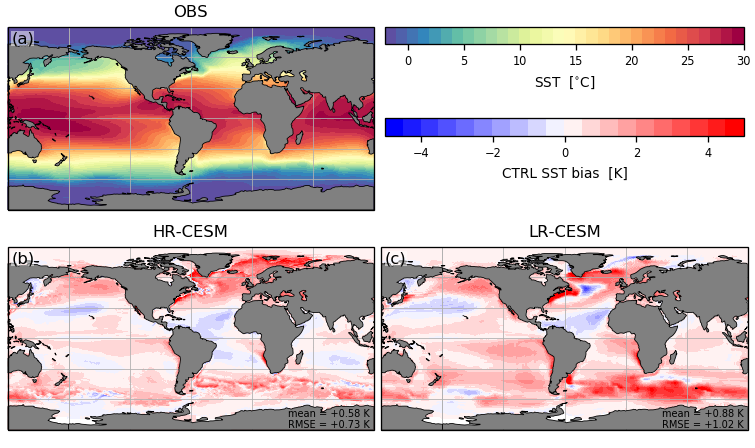

In [10]:
kw1 = dict(lat='lat', lon='lon', label='SST  [$\!^\circ\!$C]', cmap=plt.get_cmap('Spectral_r', 32), vmin=-2, vmax=30)
kw2 = dict(lat='lat', lon='lon', label='CTRL SST bias  [K]', cmap=plt.get_cmap('bwr', 20), vmin=-5, vmax=5)
dh = (regridder_ocn(SST_ocn)-SST_had_).squeeze()
dl = (regridder_low(SST_low)-SST_had_).squeeze()
weights = np.cos(np.deg2rad(dh.lat))
biases = {'HR-CESM':f'mean = {dh.weighted(weights).mean().values:+.2f} K\nRMSE = {abs(dh).weighted(weights).mean().values:+.2f} K',
          'LR-CESM':f'mean = {dl.weighted(weights).mean().values:+.2f} K\nRMSE = {abs(dl).weighted(weights).mean().values:+.2f} K',
         }
fn = f'{path_results}/thesis/2_SST_bias'
bias_maps(do=SST_had_.squeeze(), dh=dh, dl=dl, kw1=kw1, kw2=kw2, biases=biases, fn=fn)

## $P-E$

In [11]:
dah = xr.open_dataset(file_ex_atm_ctrl, decode_times=False)
dal = xr.open_dataset(file_ex_atm_lpd , decode_times=False)
doh = xr.open_mfdataset(f'{path_prace}/ctrl/ocn_yrly_EVAP_F_PREC_F_ROFF_F_*.nc', combine='nested', concat_dim='time', decode_times=False)
dol = xr.open_mfdataset(f'{path_prace}/lpd/ocn_yrly_EVAP_F_PREC_F_ROFF_F_*.nc' , combine='nested', concat_dim='time', decode_times=False)

In [12]:
erai = xr.open_dataset('../../../AMWG/obs_data/EP.ERAI_ANN_climo.nc')  # Budget Evaporation minus Precipitation
whoi = xr.open_dataset('../../../AMWG/obs_data/WHOI_ANN_climo.nc')     # monthly mean evaporation rate

In [13]:
dh = xr.open_dataset(f'{path_prace}/AMWG/HIGH_CTRL_vs_OBS/diag/spinup_pd_maxcores_f05_t12_ANN_plotvars.nc', decode_times=False)
dl = xr.open_dataset(f'{path_prace}/AMWG/LOW_CTRL_vs_OBS/diag/spinup_B_2000_cam5_f09_g16_ANN_plotvars.nc', decode_times=False)

In [14]:
# regrid P-E to ECMWF grid
PE_ocn = (doh.PREC_F+doh.EVAP_F).rename({'TLAT': 'lat', 'TLONG': 'lon'}).drop(['ULONG', 'ULAT']).mean('time').where(RMASK_ocn>0)
PE_low = (dol.PREC_F+dol.EVAP_F).rename({'TLAT': 'lat', 'TLONG': 'lon'}).drop(['ULONG', 'ULAT']).mean('time').where(RMASK_low>0)

# replace NaNs in continents with values from original grid file
lats,lons = generate_lats_lons('ocn')
PE_ocn['lat'].values = lats
PE_ocn['lon'].values = lons

In [15]:
regridder_ocn = xe.Regridder(PE_ocn, erai.EP, 'nearest_s2d', reuse_weights=True, periodic=True)
regridder_low = xe.Regridder(PE_low, erai.EP, 'nearest_s2d', reuse_weights=True, periodic=True)

Reuse existing file: nearest_s2d_2400x3600_256x512_peri.nc
Reuse existing file: nearest_s2d_384x320_256x512_peri.nc


In [16]:
erai_ = xr.open_dataset(f'{path_data}/ERAI_E-P/ERAI.EP.1979-2016.t-106.nc')

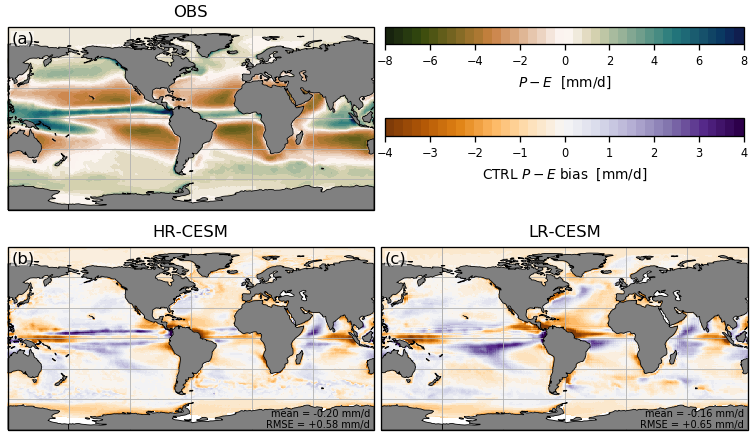

In [17]:
PmE = minus = r'$P - E$'
kw1 = dict(lat='lat', lon='lon', label=f'{PmE}  [mm/d]', cmap=plt.get_cmap('cmo.tarn', 40), vmin=-8, vmax=8)
kw2 = dict(lat='lat', lon='lon', label=f'CTRL {PmE} bias  [mm/d]', cmap=plt.get_cmap('PuOr',40), vmin=-4, vmax=4)
do = -erai.EP.squeeze()*3600*24
do.data = gaussian_filter(do, sigma=1)  # otherwise checkerboard pattern
dh = regridder_ocn(PE_ocn).values*3600*24 - do
dl = regridder_low(PE_low).values*3600*24 - do
weights = np.cos(np.deg2rad(dh.lat))
biases = {'HR-CESM':f'mean = {dh.weighted(weights).mean().values:+.2f} mm/d\nRMSE = {abs(dh).weighted(weights).mean().values:+.2f} mm/d',
          'LR-CESM':f'mean = {dl.weighted(weights).mean().values:+.2f} mm/d\nRMSE = {abs(dl).weighted(weights).mean().values:+.2f} mm/d',
         }
fn = f'{path_results}/thesis/2_P-E_bias'
bias_maps(do=do, dh=dh, dl=dl, kw1=kw1, kw2=kw2, biases=biases, fn=fn)

## salinity

In [18]:
langle, rangle, deg = r'$\langle$', r'$\rangle$', r'$^{\!\circ}\!$'
y1 = np.tanh((np.linspace(0,1, 64)-.5)*4)/2+.5 # nonlinear sampling to enhance center of colormap
y2 = np.tanh((np.linspace(0,1, 64)-.5)*3)/2+.5 # nonlinear sampling to enhance center of colormap

colors1 = cmocean.tools.crop_by_percent(cmocean.cm.dense, 10, which='max', N=None)(np.linspace(0., 1, 128))
colors2 = cmocean.tools.crop_by_percent(cmocean.cm.solar, 10, which='min', N=None)(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mymap  = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colors)(y1)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', mymap)

In [19]:
SALT_mean_orig = xr.open_dataset(f'{path_prace}/EN4/EN4_mean.nc').salinity
SALT_mean_ctrl = xr.open_dataarray(f'{path_prace}/ctrl/SALT_mean_ctrl_200-229.nc')
SALT_mean_high = xr.open_dataarray(f'{path_prace}/EN4/EN4_mean_salinity_high.nc')
SALT_mean_lpd  = xr.open_dataarray(f'{path_prace}/lpd/SALT_mean_lpd_500-529.nc')
SALT_mean_low  = xr.open_dataarray(f'{path_prace}/EN4/EN4_mean_salinity_low.nc')

In [20]:
dz_high = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False).dz
dz_low  = xr.open_dataset(file_ex_ocn_lpd , decode_times=False).dz

In [21]:
SALT_mean_ctrl_top100m = (SALT_mean_ctrl*dz_high).isel(z_t=slice(0,9)).sum('z_t')/dz_high.isel(z_t=slice(0,9)).sum('z_t')
SALT_mean_high_top100m = (SALT_mean_high*dz_high).isel(z_t=slice(0,9)).sum('z_t')/dz_high.isel(z_t=slice(0,9)).sum('z_t')
SALT_mean_lpd_top100m  = (SALT_mean_lpd *dz_low).isel(z_t=slice(0,10)).sum('z_t')/dz_low.isel(z_t=slice(0,10)).sum('z_t')
SALT_mean_low_top100m  = (SALT_mean_low *dz_low).isel(z_t=slice(0,10)).sum('z_t')/dz_low.isel(z_t=slice(0,10)).sum('z_t')

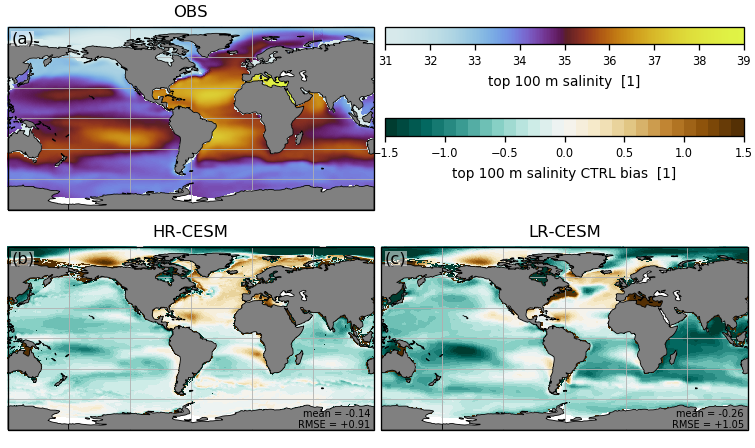

In [22]:
PmE = minus = r'$P - E$'
kw1 = dict(lat='TLAT', lon='TLONG', label='top 100 m salinity  [1]', cmap=mycmap, vmin=31, vmax=39)
kw2 = dict(label='top 100 m salinity CTRL bias  [1]', cmap=plt.get_cmap('BrBG_r', 30), vmin=-1.5, vmax=1.5)
do = SALT_mean_high_top100m.where(RMASK_ocn>0)
dh = (SALT_mean_ctrl_top100m-SALT_mean_high_top100m).where(RMASK_ocn>0)
dl = add_cyclic_POP((SALT_mean_lpd_top100m-SALT_mean_low_top100m).where(RMASK_low>0))
biases = {'HR-CESM':f'mean = {dh.weighted(dsh.TAREA).mean().values:+.2f}\nRMSE = {abs(dh).weighted(dsh.TAREA).mean().values:+.2f}',
          'LR-CESM':f'mean = {dl.weighted(add_cyclic_POP(dsl.TAREA)).mean().values:+.2f}\nRMSE = {abs(dl).weighted(add_cyclic_POP(dsl.TAREA)).mean().values:+.2f}',
         }
fn = f'{path_results}/thesis/2_salinity_bias'
bias_maps(do=do, dh=dh, dl=dl, kw1=kw1, kw2=kw2, biases=biases, fn=fn)

## std(SSH)

In [23]:
cesm_dict = dict(concat_dim='time', decode_times=False, combine='nested')
obs_dict = dict(combine='nested', concat_dim='Time', chunks={'Latitude':96, 'Longitude':270, 'Time':73})
ctrl = xr.open_mfdataset(file_ex_ocn_ctrl[:-5]+'*.nc', **cesm_dict).mean('time')
lpd = xr.open_mfdataset(file_ex_ocn_lpd[:-5]+'*.nc', **cesm_dict).mean('time')
obs = xr.open_mfdataset(f'{path_prace}/SSH/ssh_grids_v1812_*.nc', **obs_dict)

In [24]:
ctrl_std = np.sqrt(np.abs(ctrl.SSH2-ctrl.SSH**2))
ctrl_std = ctrl_std.where(RMASK_ocn!=-1)
lpd_std = np.sqrt(lpd.SSH2-lpd.SSH**2)
obs_std = np.sqrt((obs.SLA**2).mean('Time')-obs.SLA.mean('Time')**2)

In [49]:
mh = ctrl_std.weighted(dsh.TAREA).mean().compute().values
ml = lpd_std.weighted(dsl.TAREA).mean().compute().values
mo = obs_std.weighted(np.cos(np.deg2rad(obs_std.Latitude))).mean().compute().values*100
means = {'OBS'    :f'mean = {mo:+.2f} cm',
         'HR-CESM':f'mean = {mh:+.2f} cm',
         'LR-CESM':f'mean = {ml:+.2f} cm',
        }

CPU times: user 47.4 s, sys: 15.5 s, total: 1min 2s
Wall time: 47.9 s


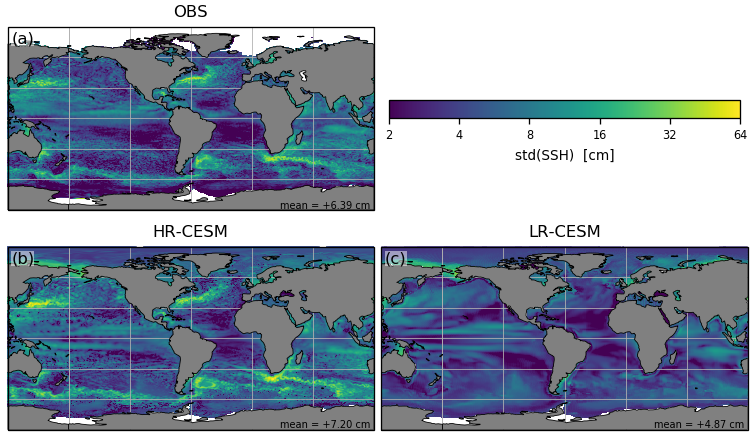

In [54]:
%%time
kw = dict(lat='Latitude', lon='Longitude', label='std(SSH)  [cm]', cmap='viridis', vmin=2, vmax=64, log=True, ticks = [2**x for x in range(1,7)])
bias_maps(do=obs_std.T*100, dh=ctrl_std, dl=add_cyclic_POP(lpd_std), kw1=kw, kw2=None, biases=means, fn=f'{path_results}/thesis/2_std_SSH')